# Wifind Data - Final Analysis 

## Author_: Chritstian Rosado

In [5]:
# importing packages 
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import shapely as shp
import seaborn 
import os
import geopandas as gpd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# important all data
startdate = "06/01/2017"
enddate = "07/17/2017"
link = 'http://wifindproject.com/wifipulling/?columns=lat%7Clng%7Cssid%7Cbssid%7Cacc%7Ctime%7Clevel\
&startdate={0}&enddate={1}&timeformat=1'.format(startdate,enddate)
print(link)

http://wifindproject.com/wifipulling/?columns=lat%7Clng%7Cssid%7Cbssid%7Cacc%7Ctime%7Clevel&startdate=06/01/2017&enddate=07/17/2017&timeformat=1


In [7]:
# loading raw data for analysis 
data = pd.read_json(link, dtype={"lng":float, "lat":float})

In [8]:
# filtering errant scans 
wifi_data = data.drop(data[data.acc > 50].index)

In [9]:
wifi_data.head(1)

,acc,bssid,lat,level,lng,ssid,time
0,19.929,fc:0a:81:c0:b4:b2,40.710426,-54.0,-74.011387,,06-12-2017 15:51:03


In [10]:
data.shape

(985106, 7)

In [11]:
wifi_data.shape

(940155, 7)

In [12]:
# errant resords removed
errant_records = data.shape[0] - wifi_data.shape[0]
print("number of errant records removed:", errant_records)

number of errant records removed: 44951


In [13]:
wifi_data[["acc", "level"]].describe()

,acc,level
count,940155.000000,940155.000000
mean,14.579580,-77.529315
std,8.622587,10.022806
min,3.000000,-99.000000
25%,9.102000,-86.000000
50%,12.136000,-79.000000
75%,19.721000,-70.000000
max,50.000000,-10.000000


In [14]:
# generating points for wifi data
def points(p):
    point = shp.geometry.Point(p)
    return point

wifi_data["geometry"] = list(map(lambda x: points(x), zip(wifi_data.lng, wifi_data.lat)))

In [15]:
wifi_data.head(1)

,acc,bssid,lat,level,lng,ssid,time,geometry
0,19.929,fc:0a:81:c0:b4:b2,40.710426,-54.0,-74.011387,,06-12-2017 15:51:03,POINT (-74.01138659999999 40.7104258)


In [118]:
wifi_data.shape

(940155, 8)

In [16]:
# loading wifi data into geopandas
wifi_shape = gpd.GeoDataFrame(wifi_data)

In [107]:
# loading housing projects shapes into geopandas
#housing_shape = gpd.GeoDataFrame.from_file("../Downloads/data/shape/Export_Output.shp")
housing_shape = gpd.GeoDataFrame.from_file("../Downloads/data/tl_2013_36_bg/tl_2013_36_bg.shp")

In [108]:
housing_shape.shape

(15463, 13)

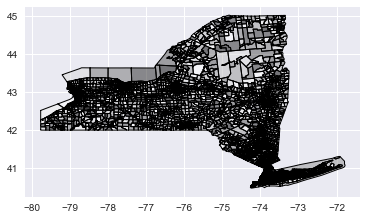

In [112]:
housing_shape.plot()

In [113]:
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
wifi_shape.crs = from_epsg(4326)
housing_shape.crs = from_epsg(4326)

In [114]:
# merging wifi data with housing shapes - blocks
housing_wifi = gpd.sjoin(wifi_shape, housing_shape, how="inner", op='intersects') #geo merger

In [119]:
housing_wifi.tail(1)

,acc,bssid,lat,level,lng,ssid,time,geometry,index_right,ALAND,...,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE
982314,23.763,12:3e:5d:c4:6a:02,40.693374,-92.0,-73.943112,optimumwifi,07-16-2017 13:37:02,POINT (-73.9431117 40.6933738),10384,39886,...,1,047,S,360470261001,+40.6936609,-073.9445151,G5030,Block Group 1,36,026100


In [116]:
housing_wifi.shape

(935847, 21)

In [120]:
housing_wifi_ = gpd.sjoin(housing_shape, wifi_shape, how="inner", op='intersects') #geo merger

In [121]:
housing_shape.shape

(15463, 13)

In [122]:
housing_wifi_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,TRACTCE,geometry,index_right,acc,bssid,lat,level,lng,ssid,time
1942,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,001501,"POLYGON ((-74.00861399999999 40.711372, -74.00...",881088,50.0,fc:0a:81:b5:ee:c2,40.710642,-77.0,-74.008483,,07-10-2017 19:47:26


In [123]:
housing_wifi_.shape

(935847, 21)

In [125]:
uni_bssid = housing_wifi_.groupby(housing_wifi_.GEOID)['bssid'].nunique()

In [126]:
uni_bssid = pd.DataFrame(uni_bssid)

In [127]:
uni_bssid["GEOID"] = uni_bssid.index
uni_bssid["uni_bssid_count"] = uni_bssid.bssid

In [128]:
uni_bssid.head()

,bssid,GEOID,uni_bssid_count
GEOID,,,
360470001004,9,360470001004,9
360470003014,306,360470003014,306
360470005013,251,360470005013,251
360470005022,214,360470005022,214
360470007001,562,360470007001,562


In [129]:
del uni_bssid["bssid"]

In [1099]:
# merge unique bssid with main data frame
housing_wifi__uni = housing_wifi_.merge(uni_bssid, on="GEOID", how="inner")

In [1100]:
housing_wifi__uni.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,geometry,index_right,acc,bssid,lat,level,lng,ssid,time,uni_bssid_count
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,"POLYGON ((-74.00861399999999 40.711372, -74.00...",881088,50.0,fc:0a:81:b5:ee:c2,40.710642,-77.0,-74.008483,,07-10-2017 19:47:26,24


In [1101]:
housing_wifi__uni.shape

(935847, 22)

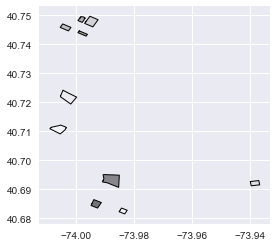

In [1102]:
housing_wifi__uni[::100000].plot()

In [ ]:
# Merge Population and median household income Data for blocks groups

In [ ]:
# Then group population, median household income, and unique_bssid wifi counts of blocks by targeted areas (10)

In [ ]:
# Then create a contigency table

In [ ]:
# genrate bar chart, chisquare test, and plot median household income vs. bssid/population

# Loading Demographic Data - Population, MHI, and Education (if possible)

# Income

In [1042]:
# aggregate income group blocks by area (10)

In [1103]:
census_block_group_income = pd.read_csv("../Downloads/data/census_block_group_income.csv", converters={"Geo_FIPS":str})

In [1104]:
census_block_group_income["GEOID"] = census_block_group_income.Geo_FIPS
del census_block_group_income["Geo_FIPS"]
census_block_group_income["MHI"] = census_block_group_income.SE_T093_001
del census_block_group_income["SE_T093_001"]

In [1105]:
census_block_group_income.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,GEOID,MHI
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,100,1,360010001001,24615


In [1106]:
census_block_group_income.shape

(15079, 14)

In [1107]:
#census_block_group_income["block_group"], census_block_group_income["census_tract"], \
#census_block_group_income["county"], census_block_group_income["state"] = \
#census_block_group_income.Geo_QName.str.split(',').str

In [1108]:
#census_block_group_income["block_group"] = census_block_group_income["block_group"].str.split(' ').str[2]
#census_block_group_income["block_group"] = 

In [1109]:
#census_block_group_income["census_tract"] = census_block_group_income["census_tract"].str.split(' ').str[3]
#census_block_group_income["census_tract"] =

In [1110]:
#census_block_group_income[census_block_group_income.county.str.contains("Richmond County")]

In [1111]:
housing_wifi__uni.GEOID.dtype

dtype('O')

In [1112]:
census_block_group_income.GEOID.dtype

dtype('O')

In [1113]:
housing_wifi_uni_by_bl_group = housing_wifi__uni.merge(census_block_group_income, on="GEOID", how="inner")

In [1114]:
housing_wifi_uni_by_bl_group.shape

(785479, 35)

In [1115]:
housing_wifi_uni_by_bl_group.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,MHI
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
1,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
2,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
3,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
4,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232


In [1116]:
housing_wifi_uni_by_bl_group.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME', 'Geo_QName',
       'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV', 'Geo_GEOCOMP',
       'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY', 'Geo_TRACT',
       'Geo_BLKGRP', 'MHI'],
      dtype='object')

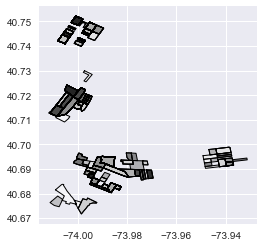

In [1117]:
housing_wifi_uni_by_bl_group[::1000].plot()

# Population

In [1057]:
# aggregate population group blocks by area (10)

In [1118]:
# Loading population data by block group
census_block_group_pop = pd.read_csv("../Downloads/data/census_block_group_pop.csv", converters={"Geo_FIPS":str})

In [1119]:
census_block_group_pop["GEOID"] = census_block_group_pop.Geo_FIPS
del census_block_group_pop["Geo_FIPS"]
census_block_group_pop["Population"] = census_block_group_pop.SE_T003_002
del census_block_group_pop["SE_T003_002"]
census_block_group_pop["Pop_Density"] = census_block_group_pop.SE_T003_001
del census_block_group_pop["SE_T003_001"]

In [1120]:
census_block_group_pop.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,SE_T003_003,GEOID,Population,Pop_Density
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,100,1,0.77441,360010001001,1031,1331.336


In [1121]:
housing_wifi_uni_by_bl_group.GEOID.dtype

dtype('O')

In [1122]:
census_block_group_pop.GEOID.dtype

dtype('O')

In [1123]:
housing_wifi_uni_by_bl_group_ = housing_wifi_uni_by_bl_group.merge(census_block_group_pop, on="GEOID", how="inner")

In [1124]:
housing_wifi_uni_by_bl_group_.shape

(785479, 50)

In [1125]:
housing_wifi_uni_by_bl_group_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_GEOCOMP_y,Geo_REGION_y,Geo_DIVISION_y,Geo_STATE_y,Geo_COUNTY_y,Geo_TRACT_y,Geo_BLKGRP_y,SE_T003_003,Population,Pop_Density
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,1,2,36,61,1501,1,0.040587,3552,87515.58


In [1126]:
housing_wifi_uni_by_bl_group_.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x',
       'Geo_AREALAND_x', 'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x',
       'Geo_REGION_x', 'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x',
       'Geo_TRACT_x', 'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y',
       'Geo_AREALAND_y', 'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y',
       'Geo_REGION_y', 'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y',
       'Geo_TRACT_y', 'Geo_BLKGRP_y', 'SE_T003_003', 'Population',
       'Pop_Density'],
      dtype='object')

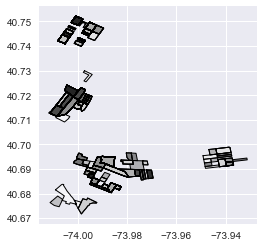

In [1127]:
housing_wifi_uni_by_bl_group_[::1000].plot()

# Education

In [1128]:
# aggregate education group blocks by area (10)

In [1129]:
# Loading education data by block group
census_block_group_edu = pd.read_csv("../Downloads/data/education_attainment.csv", converters={"Geo_FIPS":str})

In [1130]:
census_block_group_edu["GEOID"] = census_block_group_edu.Geo_FIPS
del census_block_group_edu["Geo_FIPS"]
census_block_group_edu["Pop_over_25"] = census_block_group_edu.SE_T040_001
del census_block_group_edu["SE_T040_001"]
census_block_group_edu["Less_than_HS"] = census_block_group_edu.SE_T040_002
del census_block_group_edu["SE_T040_002"]
census_block_group_edu["High_School"] = census_block_group_edu.SE_T040_003
del census_block_group_edu["SE_T040_003"]
census_block_group_edu["Some_College"] = census_block_group_edu.SE_T040_004
del census_block_group_edu["SE_T040_004"]
census_block_group_edu["Bachelors"] = census_block_group_edu.SE_T040_005
del census_block_group_edu["SE_T040_005"]
census_block_group_edu["Masters"] = census_block_group_edu.SE_T040_006
del census_block_group_edu["SE_T040_006"]
census_block_group_edu["Professional_School_Degree"] = census_block_group_edu.SE_T040_007
del census_block_group_edu["SE_T040_007"]
census_block_group_edu["Doctorate"] = census_block_group_edu.SE_T040_008
del census_block_group_edu["SE_T040_008"]

In [1131]:
census_block_group_edu.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,...,Geo_BLKGRP,GEOID,Pop_over_25,Less_than_HS,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,...,1,360010001001,685,198,181,222,62,15,7,0


In [1132]:
housing_wifi_uni_by_bl_group_.GEOID.dtype

dtype('O')

In [1133]:
census_block_group_edu.GEOID.dtype

dtype('O')

In [1134]:
housing_wifi_uni_by_bl_group__ = housing_wifi_uni_by_bl_group_.merge(census_block_group_edu, on="GEOID", how="inner")

In [1135]:
housing_wifi_uni_by_bl_group__.shape

(785479, 70)

In [1136]:
housing_wifi_uni_by_bl_group__.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_TRACT,Geo_BLKGRP,Pop_over_25,Less_than_HS,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,1501,1,3032,408,709,730,830,238,97,20


In [1137]:
housing_wifi_uni_by_bl_group__.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x',
       'Geo_AREALAND_x', 'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x',
       'Geo_REGION_x', 'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x',
       'Geo_TRACT_x', 'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y',
       'Geo_AREALAND_y', 'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y',
       'Geo_REGION_y', 'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y',
       'Geo_TRACT_y', 'Geo_BLKGRP_y', 'SE_T003_003', 'Population',
       'Pop_Density', 'Geo_NAME', 'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE',
       'Geo_COUNTY', 'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS',
       'High_School', 'Some_College',

In [1138]:
del housing_wifi_uni_by_bl_group__["index_right"]

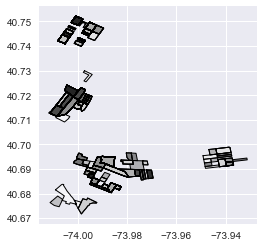

In [1078]:
housing_wifi_uni_by_bl_group__[::1000].plot()

# Loading 10 Areas

In [1139]:
# loading housing projects areas shapes into geopandas (10)
housing_areas_shape = gpd.GeoDataFrame.from_file("../Downloads/data/NewPolygons/Export_Output_4.shp")

In [1140]:
housing_areas_shape.head(1)

,cartodb_id,geometry,name,objectid,shape_area,shape_leng
0,1,POLYGON ((-73.99072057899997 40.68258755100004...,Gowanus,13,0.000022,0.026828


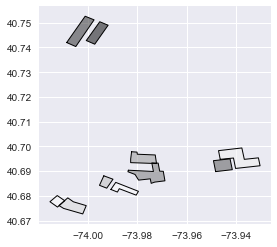

In [1141]:
housing_areas_shape.plot()

In [1142]:
housing_areas_shape.crs = from_epsg(4326)

In [1143]:
housing_gdf = gpd.sjoin(housing_wifi_uni_by_bl_group__, housing_areas_shape, how="inner", op='within')

In [1144]:
# 422365
housing_gdf.shape

(422365, 75)

In [1145]:
housing_gdf.shape

(422365, 75)

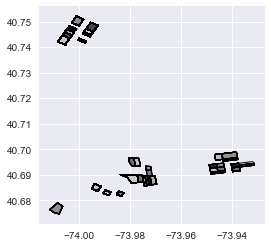

In [1146]:
housing_gdf[::100].plot()

In [1148]:
housing_gdf.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [1150]:
pd.DataFrame(housing_gdf.name.unique(), columns=["Areas"])

,Areas
0,Gowanus
1,Tompkins
2,RedHook
3,Gowanus_None
4,Ingersoll
5,Ingersoll_None
6,Tompkins_None
7,Chelsea
8,Chelsea_None


In [1151]:
housing_gdf.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Bachelors,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,name,objectid,shape_area,shape_leng
756673,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,45,21,0,0,0,1,Gowanus,13,0.000022,0.026828
756674,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,45,21,0,0,0,1,Gowanus,13,0.000022,0.026828
756675,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,45,21,0,0,0,1,Gowanus,13,0.000022,0.026828
756676,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,45,21,0,0,0,1,Gowanus,13,0.000022,0.026828
756677,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,45,21,0,0,0,1,Gowanus,13,0.000022,0.026828


# gdewfiuwefgewo

In [1236]:
area_populations = housing_gdf.groupby(["name"])["Population"].unique()

In [1237]:
area_populations = pd.DataFrame(area_populations)

In [1238]:
area_populations

,Population
name,
Chelsea,"[1546, 785, 1260, 2642, 2970, 1479]"
Chelsea_None,"[1777, 1723, 911, 1860]"
Gowanus,"[957, 3221]"
Gowanus_None,[825]
Ingersoll,"[3683, 617]"
Ingersoll_None,"[780, 853, 410, 571, 1568, 818, 914, 726]"
RedHook,[7278]
Tompkins,"[3595, 1107, 1135, 1305, 1600, 2921, 1641]"
Tompkins_None,"[584, 1091, 613, 1026, 1131]"


In [1239]:
area_populations["Population"] = list(map(lambda x: x[0].sum(),area_populations.Population))

In [1240]:
area_populations

,Population
name,
Chelsea,1546
Chelsea_None,1777
Gowanus,957
Gowanus_None,825
Ingersoll,3683
Ingersoll_None,780
RedHook,7278
Tompkins,3595
Tompkins_None,584


In [1252]:
area_populations["name"] = area_populations.index

In [1211]:
#area_populations = housing_gdf.groupby(["name","GEOID"])["Population"].unique()

In [1253]:
area_populations

,Population,name
name,,
Chelsea,1546,Chelsea
Chelsea_None,1777,Chelsea_None
Gowanus,957,Gowanus
Gowanus_None,825,Gowanus_None
Ingersoll,3683,Ingersoll
Ingersoll_None,780,Ingersoll_None
RedHook,7278,RedHook
Tompkins,3595,Tompkins
Tompkins_None,584,Tompkins_None


In [1152]:
housing_gdf.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [1162]:
unique_bssid = housing_gdf.groupby(housing_gdf.name)["bssid"].nunique()

In [1163]:
df = pd.DataFrame(unique_bssid)

In [1164]:
df["name"] = df.index

In [1165]:
df["uni_bssid_by_housing_area"] = df.bssid

In [1166]:
del df["bssid"]

In [1167]:
df

,name,uni_bssid_by_housing_area
name,,
Chelsea,Chelsea,4851
Chelsea_None,Chelsea_None,4542
Gowanus,Gowanus,1628
Gowanus_None,Gowanus_None,667
Ingersoll,Ingersoll,712
Ingersoll_None,Ingersoll_None,3218
RedHook,RedHook,313
Tompkins,Tompkins,2336
Tompkins_None,Tompkins_None,1515


In [1168]:
housing_gdf_ = housing_gdf.merge(df, on="name")

In [1169]:
housing_gdf_.shape

(422365, 76)

In [1170]:
housing_gdf_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,name,objectid,shape_area,shape_leng,uni_bssid_by_housing_area
0,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,21,0,0,0,1,Gowanus,13,0.000022,0.026828,1628


# Indentifying Open Networks

In [537]:
def open_net(x):
    x = str(x).lower()
    free_wifi_list = ["flatiron free wifi","flatiron","freewifibysurface","bryantpark.org","bryantpark",\
                     "downtownbrooklynwifi_fon","downtownbrooklyn","linknyc free wi-fi","linknyc","metrotech",\
                     "usp park wifi","usppark","red hook wifi","redhook","attwifi","guestwifi","guest",\
                      "unionsquarewifi"]
    for free_wifi in free_wifi_list:
        if x in free_wifi:
            return True
        else:
            return False

In [1171]:
def open_net(x):
    x = str(x)
    if "flatiron free wifi" in x.lower():
        return True
    else:
        if "flatiron" in x.lower():
            return True
        else:
            if "freewifibysurface" in x.lower():
                return True
            else:
                if "bryantpark.org" in x.lower():
                    return True
                else:
                    if "bryantpark" in x.lower():
                        return True
                    else:
                        if "downtownbrooklynwifi_fon" in x.lower():
                            return True
                        else:
                            if "downtownbrooklyn" in x.lower():
                                return True
                            else:
                                if "linknyc free wi-fi" in x.lower():
                                    return True
                                else:
                                    if "linknyc" in x.lower():
                                        return True
                                    else:
                                        if "metrotech" in x.lower():
                                            return True
                                        else:
                                            if "usp park wifi" in x.lower():
                                                return True
                                            else:
                                                if "usppark" in x.lower():
                                                    return True
                                                else: 
                                                    if "red hook wifi" in x.lower():
                                                        return True
                                                    else:
                                                        if "redhook" in x.lower():
                                                            return True
                                                        else:
                                                            if "attwifi" in x.lower():
                                                                return True
                                                            else:
                                                                if "guestwifi" in x.lower():
                                                                    return True
                                                                else:
                                                                    if "guest" in x.lower():
                                                                        return True
                                                                    else:
                                                                        if "unionsquarewifi" in x.lower():
                                                                            return True
                                                                        else:
                                                                            return False

In [1172]:
open_net("guest")

True

In [1173]:
housing_gdf_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,name,objectid,shape_area,shape_leng,uni_bssid_by_housing_area
0,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,21,0,0,0,1,Gowanus,13,0.000022,0.026828,1628


In [1175]:
#del housing_gdf_["open_net"]

In [1176]:
housing_gdf_["open_net"] = list(map(lambda x: open_net(x), housing_gdf_.ssid))

In [1177]:
housing_gdf_["open_net"].describe()

count     422365
unique         2
top        False
freq      400732
Name: open_net, dtype: object

In [1178]:
507094-480914

26180

In [1179]:
networks = pd.DataFrame(housing_gdf_["ssid"].unique())

In [1181]:
housing_gdf_.groupby(housing_gdf_.name)["open_net"].sum()

name
Chelsea            7435.0
Chelsea_None      11746.0
Gowanus             520.0
Gowanus_None        558.0
Ingersoll           270.0
Ingersoll_None      789.0
RedHook              58.0
Tompkins            167.0
Tompkins_None        90.0
Name: open_net, dtype: float64

In [1182]:
open_vs_non = pd.DataFrame(housing_gdf_.groupby(["name"])["open_net"].sum())

In [1183]:
open_vs_non = pd.DataFrame(housing_gdf_.groupby(["name","bssid"])["open_net"].sum())

In [1184]:
open_vs_non

open_net
name          bssid                      
Chelsea       00:02:6f:d9:a2:a0       0.0
              00:03:52:8f:23:00       0.0
              00:03:52:b5:26:10       0.0
              00:03:52:b5:26:70       0.0
              00:03:52:b5:30:20       0.0
              00:06:25:9a:ac:e8       0.0
              00:06:66:2a:66:df       0.0
              00:0c:e6:02:85:37       0.0
              00:0c:e6:02:8e:c8       8.0
              00:0d:93:7f:09:da       0.0
              00:0f:24:20:8a:d0      17.0
              00:0f:34:8f:9d:e0       0.0
              00:0f:34:97:35:c0       0.0
              00:0f:8f:38:76:20       0.0
              00:0f:f7:60:bd:20       0.0
              00:11:24:9d:78:72       0.0
              00:11:32:75:24:6f       0.0
              00:11:74:d1:d0:f0       0.0
              00:11:74:d1:d0:f1       0.0
              00:11:74:d7:34:20       0.0
              00:11:74:d7:34:30       0.0
              00:14:a4:17:d6:20       0.0
              00:14:a8:8d:95:c0       0.0
              00:14:d1:d6:5d:10       0.0
              00:14:f2:62:8f:50       0.0
              00:15:6d:dc:9b:65       0.0
              00:15:70:07:0d:f1       0.0
              00:15:70:09:21:52       0.0
              00:15:c6:5e:c4:30       0.0
              00:15:ff:55:12:be       0.0
...                                   ...
Tompkins_None fa:8f:ca:31:94:03       0.0
              fa:e9:03:06:85:ca       0.0
              fa:e9:03:06:af:e5       0.0
              fa:e9:03:06:af:e6       0.0
              fa:e9:03:07:a6:19       0.0
              fa:e9:03:07:a6:1a       0.0
              fa:e9:03:07:e0:03       0.0
              fa:e9:03:07:e0:04       0.0
              fa:e9:03:08:23:01       0.0
              fa:e9:03:08:23:0f       0.0
              fa:e9:03:08:34:f1       0.0
              fa:e9:03:0b:0d:38       0.0
              fa:e9:03:0b:0d:c3       0.0
              fa:e9:03:0c:11:88       0.0
              fa:e9:03:0d:8a:53       0.0
              fa:e9:03:0d:8a:54       0.0
              fa:e9:03:b0:04:f7       0.0
              fa:e9:03:b0:04:f8       0.0
              fa:e9:03:b0:99:47       0.0
              fa:e9:03:b0:99:48       0.0
              fa:e9:03:b1:05:ab       0.0
              fa:e9:03:b1:05:ac       0.0
              fa:e9:03:b2:1d:9e       0.0
              fa:e9:03:b3:02:7b       0.0
              fa:e9:03:b3:02:7c       0.0
              fa:e9:03:b3:04:9e       0.0
              fc:15:b4:3b:d0:06       0.0
              fc:15:b4:66:a9:a8       0.0
              fc:3f:db:23:fc:f8       0.0
              fe:3f:db:cf:40:24       0.0

[19782 rows x 1 columns]

In [1185]:
open_vs_non["open_net_counts"] = list(map(lambda x: x > 0, open_vs_non.open_net))
open_vs_non["non_open_net_counts"] = list(map(lambda x: x == 0, open_vs_non.open_net))

In [1186]:
open_vs_non["name"] = list(map(lambda x: list(x),open_vs_non.index))
open_vs_non["name"] = list(map(lambda x: x[0][:], open_vs_non["name"]))

In [1187]:
open_vs_non

open_net open_net_counts non_open_net_counts  \
name          bssid                                                             
Chelsea       00:02:6f:d9:a2:a0       0.0           False                True   
              00:03:52:8f:23:00       0.0           False                True   
              00:03:52:b5:26:10       0.0           False                True   
              00:03:52:b5:26:70       0.0           False                True   
              00:03:52:b5:30:20       0.0           False                True   
              00:06:25:9a:ac:e8       0.0           False                True   
              00:06:66:2a:66:df       0.0           False                True   
              00:0c:e6:02:85:37       0.0           False                True   
              00:0c:e6:02:8e:c8       8.0            True               False   
              00:0d:93:7f:09:da       0.0           False                True   
              00:0f:24:20:8a:d0      17.0            True               False   
              00:0f:34:8f:9d:e0       0.0           False                True   
              00:0f:34:97:35:c0       0.0           False                True   
              00:0f:8f:38:76:20       0.0           False                True   
              00:0f:f7:60:bd:20       0.0           False                True   
              00:11:24:9d:78:72       0.0           False                True   
              00:11:32:75:24:6f       0.0           False                True   
              00:11:74:d1:d0:f0       0.0           False                True   
              00:11:74:d1:d0:f1       0.0           False                True   
              00:11:74:d7:34:20       0.0           False                True   
              00:11:74:d7:34:30       0.0           False                True   
              00:14:a4:17:d6:20       0.0           False                True   
              00:14:a8:8d:95:c0       0.0           False                True   
              00:14:d1:d6:5d:10       0.0           False                True   
              00:14:f2:62:8f:50       0.0           False                True   
              00:15:6d:dc:9b:65       0.0           False                True   
              00:15:70:07:0d:f1       0.0           False                True   
              00:15:70:09:21:52       0.0           False                True   
              00:15:c6:5e:c4:30       0.0           False                True   
              00:15:ff:55:12:be       0.0           False                True   
...                                   ...             ...                 ...   
Tompkins_None fa:8f:ca:31:94:03       0.0           False                True   
              fa:e9:03:06:85:ca       0.0           False                True   
              fa:e9:03:06:af:e5       0.0           False                True   
              fa:e9:03:06:af:e6       0.0           False                True   
              fa:e9:03:07:a6:19       0.0           False                True   
              fa:e9:03:07:a6:1a       0.0           False                True   
              fa:e9:03:07:e0:03       0.0           False                True   
              fa:e9:03:07:e0:04       0.0           False                True   
              fa:e9:03:08:23:01       0.0           False                True   
              fa:e9:03:08:23:0f       0.0           False                True   
              fa:e9:03:08:34:f1       0.0           False                True   
              fa:e9:03:0b:0d:38       0.0           False                True   
              fa:e9:03:0b:0d:c3       0.0           False                True   
              fa:e9:03:0c:11:88       0.0           False                True   
              fa:e9:03:0d:8a:53       0.0           False                True   
              fa:e9:03:0d:8a:54       0.0           False                True   
              fa:e9:03:b0:04:f7       0.0           False       

In [1243]:
open_vs_non_ = pd.DataFrame(open_vs_non.groupby(open_vs_non.name)[["open_net_counts","non_open_net_counts"]].sum())

In [1251]:
open_vs_non_

,open_net_counts,non_open_net_counts,name
name,,,
Chelsea,161.0,4690.0,Chelsea
Chelsea_None,413.0,4129.0,Chelsea_None
Gowanus,14.0,1614.0,Gowanus
Gowanus_None,17.0,650.0,Gowanus_None
Ingersoll,42.0,670.0,Ingersoll
Ingersoll_None,111.0,3107.0,Ingersoll_None
RedHook,14.0,299.0,RedHook
Tompkins,38.0,2298.0,Tompkins
Tompkins_None,30.0,1485.0,Tompkins_None


In [1250]:
open_vs_non_["name"] = open_vs_non_.index

In [1254]:
#open_vs_non_
area_populations

,Population,name
name,,
Chelsea,1546,Chelsea
Chelsea_None,1777,Chelsea_None
Gowanus,957,Gowanus
Gowanus_None,825,Gowanus_None
Ingersoll,3683,Ingersoll
Ingersoll_None,780,Ingersoll_None
RedHook,7278,RedHook
Tompkins,3595,Tompkins
Tompkins_None,584,Tompkins_None


In [1192]:
housing_gdf_final = housing_gdf_.merge(open_vs_non_, on="name", how="inner")

In [1193]:
housing_gdf_final.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,index_right,cartodb_id,name,objectid,shape_area,shape_leng,uni_bssid_by_housing_area,open_net,open_net_counts,non_open_net_counts
0,29157,0,3,047,S,360470127003,+40.6825320,-073.9838257,G5030,Block Group 3,...,0,1,Gowanus,13,0.000022,0.026828,1628,False,14.0,1614.0


In [1255]:
housing_wifi_counts_normalized = open_vs_non_.merge(area_populations, on="name", how="inner")

In [1256]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population
0,161.0,4690.0,Chelsea,1546
1,413.0,4129.0,Chelsea_None,1777
2,14.0,1614.0,Gowanus,957
3,17.0,650.0,Gowanus_None,825
4,42.0,670.0,Ingersoll,3683
5,111.0,3107.0,Ingersoll_None,780
6,14.0,299.0,RedHook,7278
7,38.0,2298.0,Tompkins,3595
8,30.0,1485.0,Tompkins_None,584


In [1257]:
housing_wifi_counts_normalized["norm_open_counts"] = list(map(lambda x,y: x/y,\
                                                              housing_wifi_counts_normalized.open_net_counts,\
                                                              housing_wifi_counts_normalized.Population))
housing_wifi_counts_normalized["norm_non_open_counts"] = list(map(lambda x,y: x/y, housing_wifi_counts_normalized.non_open_net_counts,\
                                                                 housing_wifi_counts_normalized.Population))

In [1258]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population,norm_open_counts,norm_non_open_counts
0,161.0,4690.0,Chelsea,1546,0.104140,3.033635
1,413.0,4129.0,Chelsea_None,1777,0.232414,2.323579
2,14.0,1614.0,Gowanus,957,0.014629,1.686520
3,17.0,650.0,Gowanus_None,825,0.020606,0.787879
4,42.0,670.0,Ingersoll,3683,0.011404,0.181917
5,111.0,3107.0,Ingersoll_None,780,0.142308,3.983333
6,14.0,299.0,RedHook,7278,0.001924,0.041083
7,38.0,2298.0,Tompkins,3595,0.010570,0.639221
8,30.0,1485.0,Tompkins_None,584,0.051370,2.542808


In [1298]:
bar_plot = housing_wifi_counts_normalized[["name","norm_open_counts","norm_non_open_counts"]]

In [1299]:
bar_plot

,name,norm_open_counts,norm_non_open_counts
0,Chelsea,0.104140,3.033635
1,Chelsea_None,0.232414,2.323579
2,Gowanus,0.014629,1.686520
3,Gowanus_None,0.020606,0.787879
4,Ingersoll,0.011404,0.181917
5,Ingersoll_None,0.142308,3.983333
6,RedHook,0.001924,0.041083
7,Tompkins,0.010570,0.639221
8,Tompkins_None,0.051370,2.542808


In [1300]:
bar_plot.index = bar_blot.name

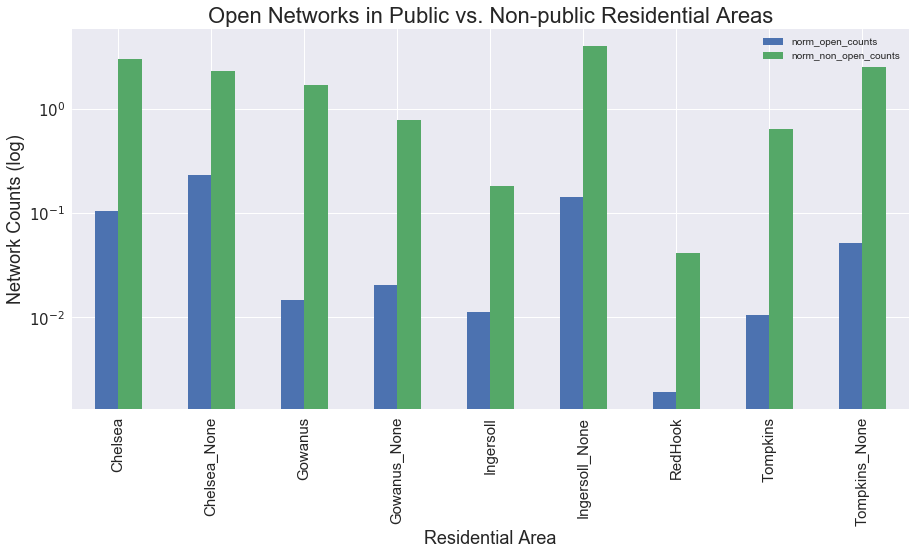

In [1454]:
ax = bar_plot.plot(kind='bar', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 7), legend=True, fontsize=15)
ax.set_title("Open Networks in Public vs. Non-public Residential Areas",fontsize=22)
ax.set_xlabel("Residential Area", fontsize=18)
ax.set_ylabel("Network Counts (log)", fontsize=18)
ax.set_yscale("log")

In [1302]:
bar_plot

,name,norm_open_counts,norm_non_open_counts
name,,,
Chelsea,Chelsea,0.104140,3.033635
Chelsea_None,Chelsea_None,0.232414,2.323579
Gowanus,Gowanus,0.014629,1.686520
Gowanus_None,Gowanus_None,0.020606,0.787879
Ingersoll,Ingersoll,0.011404,0.181917
Ingersoll_None,Ingersoll_None,0.142308,3.983333
RedHook,RedHook,0.001924,0.041083
Tompkins,Tompkins,0.010570,0.639221
Tompkins_None,Tompkins_None,0.051370,2.542808


In [1303]:
contingency_table_Chelsea = bar_plot[bar_blot.index.str.contains("Chelsea","Chelsea_None")][["norm_open_counts","norm_non_open_counts"]]

In [1304]:
contingency_table_Chelsea

,norm_open_counts,norm_non_open_counts
name,,
Chelsea,0.104140,3.033635
Chelsea_None,0.232414,2.323579


In [1306]:
from scipy.stats import chisquare

In [1317]:
obs = np.array([[0.104140,3.033635],[0.232414,2.323579]])

In [1316]:
obs

array([[ 0.10414 ,  0.232414],
       [ 3.033635,  2.323579]])

In [1315]:
chisquare(obs)

Power_divergenceResult(statistic=array([ 2.73504026,  1.71086973]), pvalue=array([ 0.09816903,  0.19087257]))

In [1318]:
obs

array([[ 0.10414 ,  3.033635],
       [ 0.232414,  2.323579]])

In [1319]:
chisquare(obs)

Power_divergenceResult(statistic=array([ 0.04889028,  0.09411226]), pvalue=array([ 0.82500564,  0.75901295]))

In [1378]:
area_MHI = housing_gdf.groupby(["name"])["MHI"].unique()

In [1379]:
#housing_gdf.groupby(["name", "GEOID"])["MHI"].unique()

In [1380]:
area_MHI

name
Chelsea                  [13210, 49674, 13889, 29178, 75644, 39788]
Chelsea_None                           [52917, 43071, 70741, 55000]
Gowanus                                              [15868, 13202]
Gowanus_None                                                [49444]
Ingersoll                                            [11185, 14091]
Ingersoll_None    [52500, 34489, 71779, 61771, 37071, 42101, 345...
RedHook                                                     [10372]
Tompkins            [13218, 14348, 13229, 9563, 9934, 11859, 13043]
Tompkins_None                    [8561, 14426, 18814, 17083, 18167]
Name: MHI, dtype: object

In [1381]:
area_MHI = pd.DataFrame(area_MHI)

In [1382]:
area_MHI

,MHI
name,
Chelsea,"[13210, 49674, 13889, 29178, 75644, 39788]"
Chelsea_None,"[52917, 43071, 70741, 55000]"
Gowanus,"[15868, 13202]"
Gowanus_None,[49444]
Ingersoll,"[11185, 14091]"
Ingersoll_None,"[52500, 34489, 71779, 61771, 37071, 42101, 345..."
RedHook,[10372]
Tompkins,"[13218, 14348, 13229, 9563, 9934, 11859, 13043]"
Tompkins_None,"[8561, 14426, 18814, 17083, 18167]"


In [1383]:
area_MHI["MHI"] = list(map(lambda x: x[:].sum(), list(area_MHI.MHI)))

In [1384]:
area_MHI.MHI[2].sum()

29070

In [1385]:
area_MHI["name"] = area_MHI.index

In [1386]:
scatter_plot = bar_plot.merge(area_MHI, on="name")

In [1387]:
scatter_plot.index = scatter_plot.name

In [1388]:
scatter_plot

,name,norm_open_counts,norm_non_open_counts,MHI
name,,,,
Chelsea,Chelsea,0.104140,3.033635,221383
Chelsea_None,Chelsea_None,0.232414,2.323579,221729
Gowanus,Gowanus,0.014629,1.686520,29070
Gowanus_None,Gowanus_None,0.020606,0.787879,49444
Ingersoll,Ingersoll,0.011404,0.181917,25276
Ingersoll_None,Ingersoll_None,0.142308,3.983333,374253
RedHook,RedHook,0.001924,0.041083,10372
Tompkins,Tompkins,0.010570,0.639221,85194
Tompkins_None,Tompkins_None,0.051370,2.542808,77051


In [1375]:
#scatter_plot["mih_v_norm_open_counts"] = zip(scatter_plot.norm_open_counts,scatter_plot.MHI)
#scatter_plot["mih_v_norm_non_open_counts"] = zip(scatter_plot.norm_non_open_counts,scatter_plot.MHI)

In [ ]:
ax = bar_plot.plot(kind='bar', title ="Open Networks in Public vs. None-public Residential Areas", \
                   figsize=(15, 10), legend=True, fontsize=15)

ax.set_title("Open Networks in Public vs. None-public Residential Areas",fontsize=22)
ax.set_xlabel("Residential Area", fontsize=18)
ax.set_ylabel("Network Counts (log)", fontsize=18)
ax.set_yscale("log")

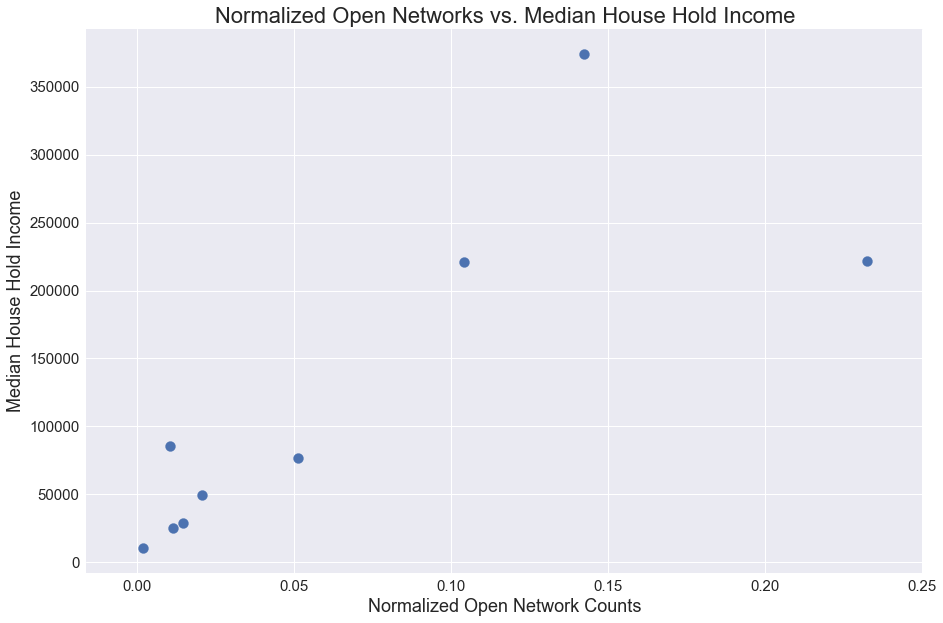

In [1400]:
ax = scatter_plot.plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 10), legend=True, fontsize=15, x='norm_open_counts', y='MHI', s=100)
ax.set_title("Normalized Open Networks vs. Median House Hold Income",fontsize=22)
ax.set_xlabel("Normalized Open Network Counts", fontsize=18)
ax.set_ylabel("Median House Hold Income", fontsize=18)
#ax.set_yscale("log")

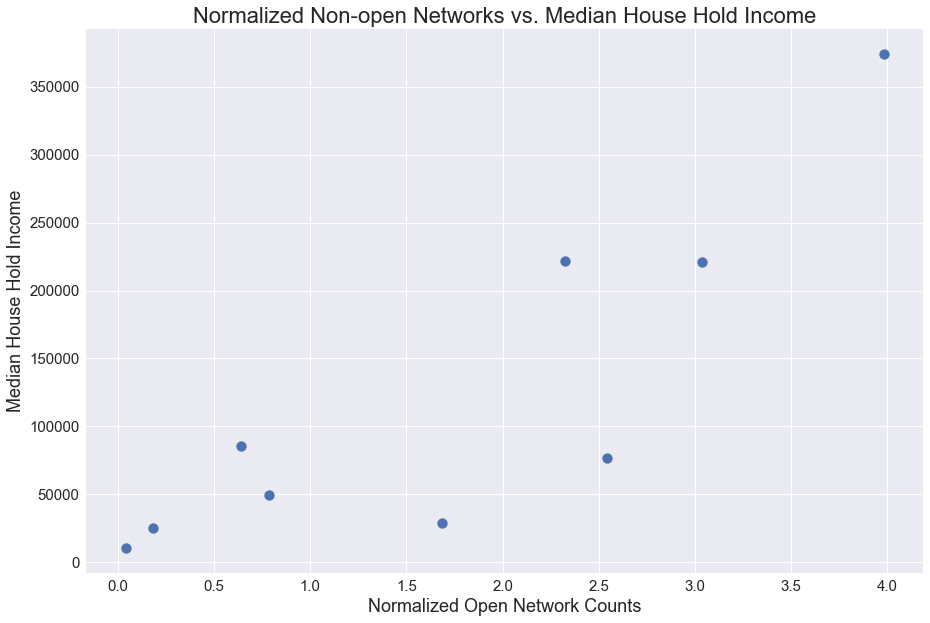

In [1402]:
ax = scatter_plot.plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 10), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=100)
ax.set_title("Normalized Non-open Networks vs. Median House Hold Income",fontsize=22)
ax.set_xlabel("Normalized Open Network Counts", fontsize=18)
ax.set_ylabel("Median House Hold Income", fontsize=18)
#ax.set_yscale("log")

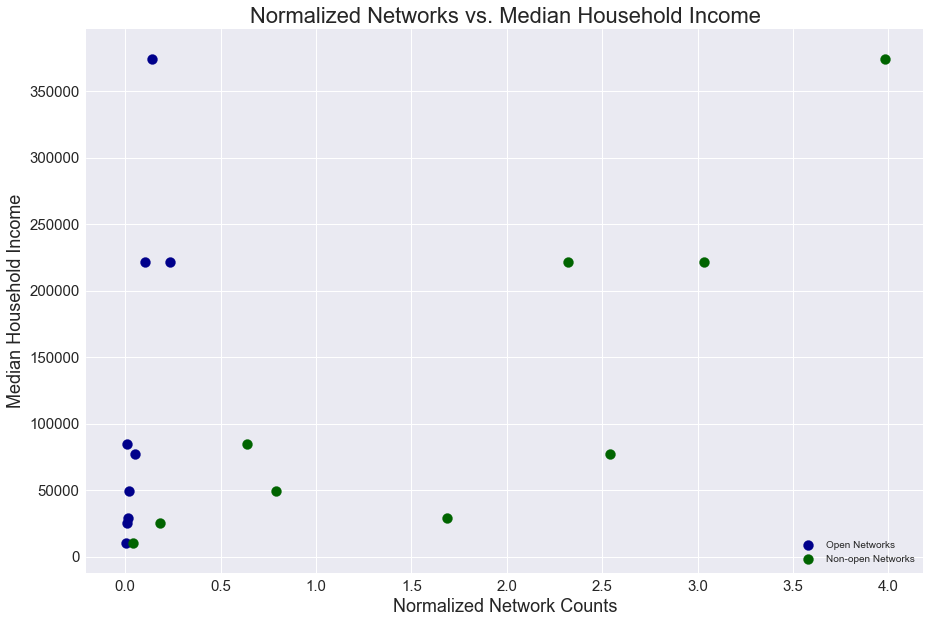

In [1429]:
ax = scatter_plot.plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 10), legend=True, fontsize=15, x='norm_open_counts', y='MHI', s=100, color='DarkBlue',\
                      label='Open Networks')

scatter_plot.plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 10), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=100,\
                       color='DarkGreen', label='Non-open Networks', ax=ax)
ax.set_title("Normalized Networks vs. Median Household Income",fontsize=22)
ax.set_xlabel("Normalized Network Counts", fontsize=18)
ax.set_ylabel("Median Household Income", fontsize=18)

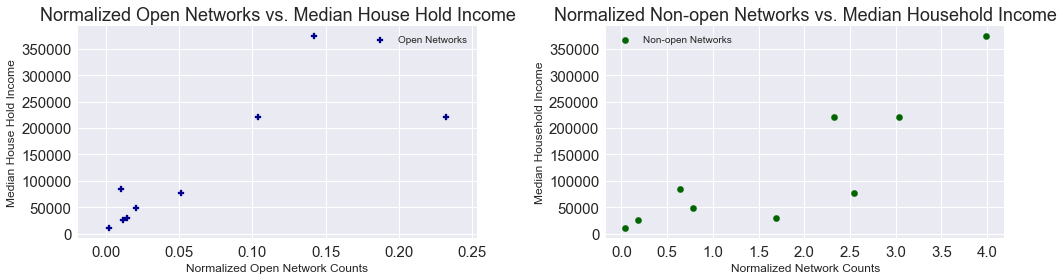

In [1449]:
ax1 = plt.subplot(1,2,1)

scatter_plot.plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_open_counts', y='MHI', s=40, color='DarkBlue',\
                      label='Open Networks', ax=ax1, marker="P")
ax1.set_title("Normalized Open Networks vs. Median House Hold Income",fontsize=18)
ax1.set_xlabel("Normalized Open Network Counts", fontsize=12)
ax1.set_ylabel("Median House Hold Income", fontsize=12)

ax2 = plt.subplot(1,2,2)

scatter_plot.plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkGreen', label='Non-open Networks', ax=ax2)

ax2.set_title("Normalized Non-open Networks vs. Median Household Income",fontsize=18)
ax2.set_xlabel("Normalized Network Counts", fontsize=12)
ax2.set_ylabel("Median Household Income", fontsize=12)
plt.tight_layout()
    
